In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
from open_spiel.python.algorithms import random_agent

import sys
sys.path.append("../")
#from utils.reinforcement_learning.dqn_HD import DQN
from utils.reinforcement_learning.dqn import DQN
from utils.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel,EvaluateACTION
from utils.validation import get_Validation, area_under_curve
from utils.environment.CIgame import GraphGame
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment
from igraph import Graph

def input_graph(graph_path,file):
    GRAPH = Graph.Read_Ncol(graph_path+str(file)+".txt", directed=False)
    nodes = [v.index for v in GRAPH.vs]
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(GRAPH)  
    Graph.simplify(GRAPH)
    return GRAPH, map

def implement_GNN(model,parameter_path,GRAPH):
    params = Params(parameter_path)
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    attacker = DQN(player_id=0,
                    state_representation_size=params.centrality_features,
                    hidden_layers_sizes= params.hidden_layers,
                   global_feature_size =params.global_features,
                   num_actions=num_actions)
    attacker._q_network.load_state_dict(model["_q_network"])
    attacker._optimizer.load_state_dict(model["_optimizer"])
    agents = [attacker]
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    return rewards, lcc, actions

def implement_random_GNN(agents,GRAPH):
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    return rewards, lcc, actions
    
def implement_Bench(fname,GRAPH, map):
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    action_list = np.loadtxt(fname, dtype=int)
    #action_list= [map.get(str(a)) for a in action_list]
    rewards, lcc, actions = EvaluateACTION(action_list,GRAPH)
    return rewards, lcc, actions


def visual_evaluation(graph_path,file_list,attacker,title,plot_grid,grid):    
    figure, axis = plt.subplots(grid[0],grid[1],sharey=True,sharex=True,figsize=(12, 10))
    #figure, axis = plt.subplots(grid[0],grid[1],sharey=True,sharex=True,figsize=(22, 20))
    for i, graph_name in enumerate(file_list):
        print(graph_name, end=",")
        GRAPH, map = input_graph(graph_path,graph_name)
        N = GRAPH.vcount()
        rewards_ba, lcc_ba, actions_ba = implement_GNN(attacker[0],attacker[1],GRAPH.copy())
        #FINDER MODEl
        #FINDER Best Re-Trained  iteration
        path = "../MAS/FINDER/FINDER_ReTrained/"
        fname = path+graph_name+".txt"
        rewards_Finder, lcc_Finder, actions = implement_Bench(fname,GRAPH.copy(),map)
        if (len(lcc_Finder) == 0):
            lcc_Finder = None
        #CI
        path = "../MAS/CI/"
        fname = path+graph_name+".txt"
        rewards_CI, lcc_CI, actions = implement_Bench(fname,GRAPH.copy(),map)
        
        #CoreHD
        path = "../MAS/CoreHD/"
        fname = path+graph_name+".txt"
        rewards_CoreHD, lcc_CoreHD, actions =  implement_Bench(fname,GRAPH.copy(),map)
        
        '''#Random
        attacker = random_agent.RandomAgent(player_id=1, num_actions=N)
        rewards_random, lcc_random, actions_random = implement_random_GNN([attacker,attacker],GRAPH.copy())'''


        x =  np.flip(np.arange(N)[N:0:-1]/N)
        
        #Plot LCC Decrease
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_ba)],np.array(lcc_ba)/N, 'red',label='Trained Attacker [BA model]')
        if lcc_Finder != None:
            axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_Finder)],np.array(lcc_Finder)/N, 'aquamarine',label='FINDER ReTrained')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CI)],np.array(lcc_CI)/N, 'pink',label='CI')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CoreHD)],np.array(lcc_CoreHD)/N, 'brown',label='CoreHD')
        axis[plot_grid[i][0],plot_grid[i][1]].set_title(graph_name, fontdict={'fontsize': 18})
        #plt.plot(x[:len(lcc_random)],np.array(lcc_random)/N, 'blue',label='Random')
    print()
    figure.text(0.5, 0.05,"Fraction of Nodes Removed" , fontsize = 18,  ha='center')
    figure.text(0.05, 0.5, "LCC/No. of Nodes", fontsize = 18,  va='center', rotation='vertical')
    #plt.title("LCC vs No. of Nodes for Agents")
    plt.savefig("./Figure_WithoutFeature/"+title)
    plt.show()

In [7]:

BA =  70000
parameter = ["./utils/params_WithoutFeature.json"]
attacker= [torch.load('./model/CI_BA_Graph_WithoutFeature/model_BAGraph_'+str(BA))]


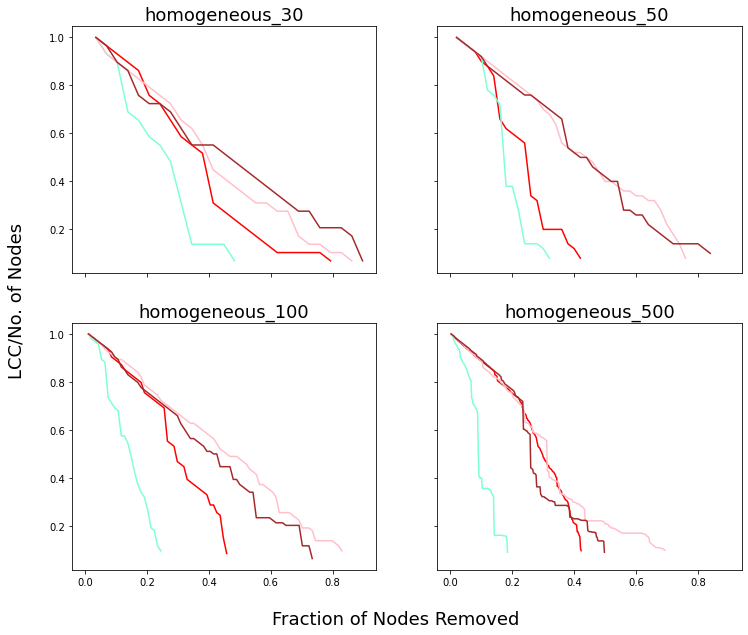

In [9]:
graph_path= "./Dataset/HomogeneityGraph/"
file_list =  ['homogeneous_30','homogeneous_50','homogeneous_100','homogeneous_500']
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],"homogeneous.pdf",[[0,0],[0,1],[1,0],[1,1]],[2,2])

In [10]:

BA =  89500 
parameter = ["./utils/params_WithoutFeature.json"]
attacker= [torch.load('./model/CI_BA_Graph_WithoutFeature/model_BAGraph_'+str(BA))]


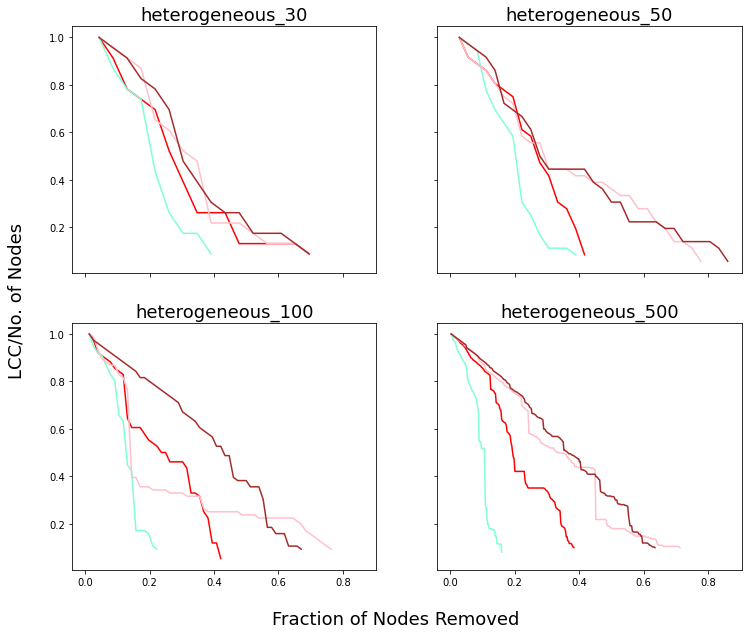

In [11]:
# 'ba_300_100_cycle_5',
graph_path= "./Dataset/HomogeneityGraph/"
file_list =  ['heterogeneous_30','heterogeneous_50','heterogeneous_100','heterogeneous_500']
x, y = 7, 5
grid_plot = [[i,j] for i in range(x) for j in range(y)]
grid_plot.pop((5*5 -1))
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],"heterogeneous.pdf",[[0,0],[0,1],[1,0],[1,1]],[2,2])


In [16]:

BA =  89500 
parameter = ["./utils/params_WithoutFeature.json"]
attacker= [torch.load('./model/CI_BA_Graph_WithoutFeature/model_BAGraph_'+str(BA))]


corruption,foodweb-baywet,inf-USAir97,moreno_crime_projected,opsahl-openflights,household,faa,facebook,powergrid,netscience,HI-II-14,bio-grid-human,


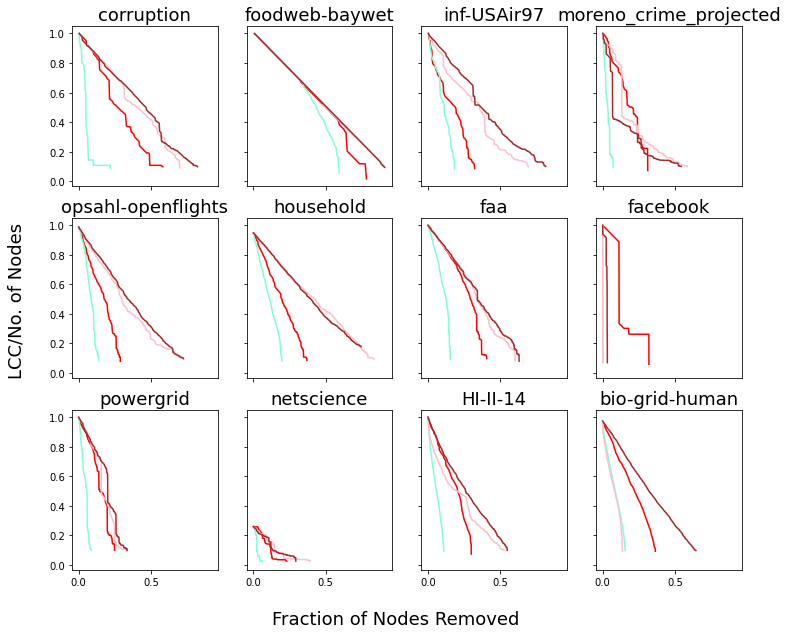

In [17]:
file_list = ['HI-II-14','bio-grid-human']#['Digg_LCC']#['Gnutella31']
#file_list = ['GeneInteraction','ReliableInteraction']#['Gnutella31']bio-grid-human.txt
file_list = ["corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','faa','facebook','powergrid','netscience','HI-II-14','bio-grid-human']
graph_path =  "./Dataset/Real/"
x, y = 3, 4
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#grid_plot.pop((5*5 -1))
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],"real.pdf",grid_plot,[x,y])


In [ ]:
graph_path = "./Dataset/GeneNetwork/"
file_list =  ["COAD","HNSC","KICH","PRAD","UCEC"]
x, y = 3, 2
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#grid_plot.pop((5*5 -1))
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],"geneinteraction.pdf",grid_plot,[x,y])


In [ ]:
file_list = ['Digg_LCC','Gnutella31']
graph_path =  "./Dataset/Real/"
x, y = 1, 1
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#grid_plot.pop((5*5 -1))
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],"large.pdf",grid_plot,[x,y])
